# Reading a raster file and print statistics

## GDAL

- first we will do something in GDAL and then in rasterio to see the differences

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from osgeo import gdal, osr
import sys
import struct
import numpy
import os

In [5]:
dataset = gdal.Open(os.path.join("dsm.tif"), gdal.GA_ReadOnly)
if dataset is None:
    print("Open failed.\n")
    sys.exit(1)

#
# Query and print dataset Information
#

# Dataset driver
print('Driver: ', dataset.GetDriver().ShortName, '/',
      dataset.GetDriver().LongName)

# Raster size (rows/columns/nr of bands)
print('Size is ', dataset.RasterXSize, 'x', dataset.RasterYSize,
      'x', dataset.RasterCount)

# Georeference
print('Projection is ', dataset.GetProjection())

# Raster location / Pixel size / raster orientation
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print('Origin = (', geotransform[0], ',', geotransform[3], ')')
    print('Pixel Size = (', geotransform[1], ',', geotransform[5], ')')
    if geotransform[2] != 0. or geotransform[4] != 0.:
        print("Oblique raster orientation.")
    else:
        print("Raster parallel to coordinate axis.")

Driver:  GTiff / GeoTIFF
Size is  451 x 351 x 1
Projection is  LOCAL_CS["X-Y-Z",UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( 527799.5 , 5340350.5 )
Pixel Size = ( 1.0 , -1.0 )
Raster parallel to coordinate axis.


- Fetching a raster band
- note that the first band is adressed with index 1!!

In [6]:
band = dataset.GetRasterBand(1)

print('Band Type=', gdal.GetDataTypeName(band.DataType))

minVal = band.GetMinimum()
maxVal = band.GetMaximum()
if minVal is None or maxVal is None:
    minVal, maxVal = band.ComputeRasterMinMax(1)
print('Min=%.3f, Max=%.3f' % (minVal, maxVal))

if band.GetOverviewCount() > 0:
    print('Band has ', band.GetOverviewCount(), ' overviews.')

if not band.GetRasterColorTable() is None:
    print('Band has a color table with ', 
        band.GetRasterColorTable().GetCount(), ' entries.')

nodata = band.GetNoDataValue()
print("Value indicating data voids:", nodata)

Band Type= Float32
Min=258.803, Max=293.878
Value indicating data voids: 9999.0


Reading raster data in GDAL can be done several ways. We will use two:

- ReadRaster method, sometimes seen in older code, just so you know what it does
- ReadAsArray method, reads directly into numpy array

In [7]:
# Read first line (starting from upper left corner)
scanline = band.ReadRaster(
    0, 0, band.XSize, 1, band.XSize, 1, gdal.GDT_Float32)
print("ReadRaster returned: ", scanline)
tuple_of_floats = struct.unpack('f' * band.XSize, scanline)
print("Converted to floats:", tuple_of_floats)

ReadRaster returned:  b"\x17\x85\x83C\xd3\x83\x83Cd\x84\x83C#\x85\x83C\x03\x85\x83C\xc0\x85\x83C6\x85\x83C3\x88\x83Cn\x87\x83C\xb1\x88\x83C\xa5\x86\x83C\xbe\x84\x83C`\x82\x83C\x10\x80\x83C\xee}\x83C\x85|\x83C/}\x83C\xb6}\x83C\xda|\x83C4}\x83C\xa3z\x83C\x97x\x83C'x\x83C\xc6u\x83C\xc6v\x83CXx\x83C\x94x\x83C\xb0x\x83Ctw\x83C\x92w\x83C1w\x83C\xa0w\x83C\\x\x83C y\x83Csy\x83C\xd7y\x83C\x88w\x83C\xb9y\x83C\xa5|\x83C\x81\x80\x83C\xe0\x85\x83C\x7f\x89\x83C\xdf\x8c\x83C\x1a\x91\x83C\x99\x91\x83C]\x91\x83C\xb8\x90\x83C\xd5\x8e\x83C\x81\x8f\x83C\xa1\x8e\x83Cm\x8e\x83C:\x90\x83C\xc6\x8e\x83C\xde\x8d\x83C\xf4\x8a\x83C\xd4\x89\x83C\xee\x86\x83Co\x85\x83C\x1bv\x83C^z\x83CR\x8c\x83CZ\xd7\x83C\xe8;\x83C\xce\xf4\x82C\x02\xc7\x82C\x10\xad\x82C<\x8f\x82C\x06\x80\x82CTm\x82C\xf6f\x82C\xae`\x82CT]\x82C\x9fW\x82C\x85H\x82C\xde7\x82C^/\x82C\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x0

In [8]:
# we can also read the first line using ReadAsArray directly
array = band.ReadAsArray(0, 0, band.XSize, 1)
print(array.shape)
print(len(tuple_of_floats))
# close the dataset
dataset = None

(1, 451)
451


## Rasterio

GTiff
451 351 (351, 451)
Origin = ( 527799.5 , 5340350.5 )
Pixel Size = ( 1.0 , -1.0 )
LOCAL_CS["X-Y-Z",UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
(1.0, 1.0)
[9999.0]
['float32']
(1, 351, 451)
258.803 9999.0
(351, 451)


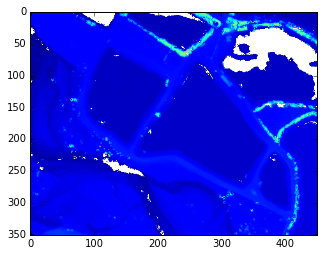

258.803 293.878
(1, 451)


In [9]:
import rasterio
with rasterio.drivers():
    with rasterio.open(os.path.join("dsm.tif")) as src:
        print(src.driver)
        print(src.width, src.height, src.shape)
        # affine property contains the geotransformation parameters
        print('Origin = (', src.affine[2], ',', src.affine[5], ')')
        print('Pixel Size = (', src.affine[0], ',', src.affine[4], ')')
        print(src.crs_wkt) 
        print(src.res)
        print(src.nodatavals)
        print(src.dtypes)
        # reading statistics from metadata not yet supported
        # but we can calculate them using numpy.

        # reading data
        # can also be used with band indices, defaults to reading all bands
        banddata = src.read() 
        print(banddata.shape)
        print(banddata.min(), banddata.max())
        # default is to read the data as is 
        banddata = src.read(indexes=1, masked=True) 
        print(banddata.shape)
        plt.imshow(banddata)
        plt.show()
        print(banddata.min(), banddata.max())
        # we can also just read a window of the data like we did above using the GDAL interface
        banddata = src.read(indexes=1, masked=True, window=((0, 1), (0, src.width)))
        print(banddata.shape)
        # dataset is closed because we used a context manager


# Raster data format conversion

convert from one datatype to another - gdaltranslate would do something similar
in the command line

## GDAL

In [11]:
src_filename = os.path.join("dsm.tif")
dst_filename = os.path.join("dsm.jpeg")

dname = "AAIGrid"  # ArcInfo (ESRI) ASCII Grid
driver = gdal.GetDriverByName(dname)
metadata = driver.GetMetadata()
if gdal.DCAP_CREATE in metadata \
   and metadata[gdal.DCAP_CREATE] == 'YES':
    print('Driver %s supports Create() method.' % dname)
if gdal.DCAP_CREATECOPY in metadata \
   and metadata[gdal.DCAP_CREATECOPY] == 'YES':
    print('Driver %s supports CreateCopy() method.' % dname)

src_ds = gdal.Open(src_filename)
dst_ds = driver.CreateCopy(dst_filename, src_ds, 0)

# Once we're done, close properly the dataset
dst_ds = None
src_ds = None


Driver AAIGrid supports CreateCopy() method.


## Rasterio

makes the copying of data easier but does currently not allow access to driver
metadata.

In [12]:
with rasterio.drivers() as drivers:

    rasterio.copy(
        src_filename,
        dst_filename,
        driver='AAIGrid')


# Dataset creation

We can create datasets from data in python, e.g. numpy arrays.

In [13]:
# create buffer containing pixel values as numpy array
raster = numpy.zeros((5, 5), dtype=numpy.uint8)
raster[1:4, 1:4] = 120
raster[2, 2] = 255
print("Pixel values:\n", raster)

# Set Spatial References System
srs = osr.SpatialReference()
srs.SetUTM(33, 1)
srs.SetWellKnownGeogCS('WGS84')

dst_filename = os.path.join("pyramid.tif")
driver = gdal.GetDriverByName("GTiff")

# Create empty raster dataset with 5x5 pixels (single band) of type 1-byte
# unsigned int
dst_ds = driver.Create(dst_filename, 5, 5, 1, gdal.GDT_Byte)

# Set the geo-transformation (i.e. 6 parameters of 2D affine transformation)
dst_ds.SetGeoTransform([527800.000, 10, 0, 5340000, 0, -10])
dst_ds.SetProjection(srs.ExportToWkt())
dst_ds.GetRasterBand(1).WriteArray(raster)
# Once we're done, close properly the dataset
dst_ds = None

Pixel values:
 [[  0   0   0   0   0]
 [  0 120 120 120   0]
 [  0 120 255 120   0]
 [  0 120 120 120   0]
 [  0   0   0   0   0]]


Creation of a new dataset is not that different right now. One advantage is the
context manager and that we do not need to know the gdal datatype

In [18]:
from rasterio import transform

trs = transform.from_origin(527800.000, 5340000, 451, 351)

with rasterio.drivers():
    with rasterio.open(os.path.join("pyramid_rasterio.tif"), "w",
                       driver='GTiff', count=1, width=5, height=5, dtype=numpy.uint8,
                       crs=srs.ExportToWkt(),
                       transform=trs) as dst:
        dst.write_band(1, raster)
        print(dst.read(indexes=1))


[[  0   0   0   0   0]
 [  0 120 120 120   0]
 [  0 120 255 120   0]
 [  0 120 120 120   0]
 [  0   0   0   0   0]]


# Other rasterio features
- reprojection
- masking
- shape rasterization

See the [rasterio documentation](https://github.com/mapbox/rasterio/blob/master/docs/)

# Exercise

Read, inspect and plot a 10x10 pixel subset of the file *dsm_zco.tif* using either the GDAL API or rasterio.

See the rasterio [window documentation](https://github.com/mapbox/rasterio/blob/master/docs/windowed-rw.rst).